In [ ]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

In [ ]:
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import os


# Read the CSV and Perform Basic Data Cleaning

In [3]:
df = pd.read_csv("exoplanet_data.csv")
# Dropping the null columns where all values are null
df = df.dropna(axis='columns', how='all')
# Dropping the null rows
df = df.dropna()
df.head()
#Getting rid of space on FALSE_POSITIVES
df.replace(to_replace ="FALSE POSITIVE", 
                 value ="FALSE_POSITIVE",
          inplace=True) 


# Select your features (columns)

In [26]:
# Setting features that will also be used as my x values.
# Instead of selecting 40 columns I dropped the koi_disposition column since its being used for the Y. 
X = df.drop(columns = ['koi_disposition'])
Y= df["koi_disposition"]

print(X.shape, Y.shape)

(6991, 40) (6991,)


# Create a Train Test Split

Use `koi_disposition` for the y values

In [27]:
#Creating a train test split
from sklearn.model_selection import train_test_split

X = pd.get_dummies(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state= 40)

In [30]:
X_train.head()


,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
3866,0,1,0,0,6.714248,0.000008,-0.000008,134.31703,0.00137,-0.00137,...,-179,4.508,0.102,-0.085,0.800,0.096,-0.096,299.08057,44.295010,17.376
2059,0,0,0,0,2.118894,0.000008,-0.000008,132.80420,0.00290,-0.00290,...,-182,4.583,0.038,-0.152,0.796,0.176,-0.075,288.21072,42.556808,15.855
3086,0,1,1,1,0.512583,0.000003,-0.000003,131.77571,0.00456,-0.00456,...,-232,4.471,0.056,-0.224,0.999,0.333,-0.111,295.46341,46.011230,15.484
6901,0,0,0,1,1.332544,0.000012,-0.000012,132.06788,0.00841,-0.00841,...,-191,4.543,0.099,-0.081,0.734,0.100,-0.082,294.94775,46.671951,15.840
5580,0,1,0,0,52.884577,0.001744,-0.001744,147.01058,0.00373,-0.00373,...,-233,4.420,0.067,-0.202,1.078,0.333,-0.133,290.40158,37.942009,15.694


# Pre-processing

Scale the data using the MinMaxScaler and perform some feature selection

In [41]:
# Scaling the data/ Preprocessing data set prior to fitting
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

X_scaler = MinMaxScaler().fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

print(X.shape, Y.shape)

(6991, 40) (6991,)


In [70]:
# Label encoding the responses (y)
label_encoder = LabelEncoder()
label_encoder.fit(Y_train)

encoded_y_train = label_encoder.transform(Y_train)
encoded_y_test = label_encoder.transform(Y_test)

In [73]:
# Converting encoded labels to one hot encoding
y_train_categorical = to_categorical(encoded_y_train)
y_test_categorical = to_categorical(encoded_y_test)

(5243, 3)

# Train the Model



k: 1, Train/Test Score: 1.000/0.803
k: 3, Train/Test Score: 0.892/0.812
k: 5, Train/Test Score: 0.868/0.829
k: 7, Train/Test Score: 0.863/0.827
k: 9, Train/Test Score: 0.854/0.828
k: 11, Train/Test Score: 0.850/0.826
k: 13, Train/Test Score: 0.846/0.831
k: 15, Train/Test Score: 0.842/0.831
k: 17, Train/Test Score: 0.839/0.831
k: 19, Train/Test Score: 0.836/0.830


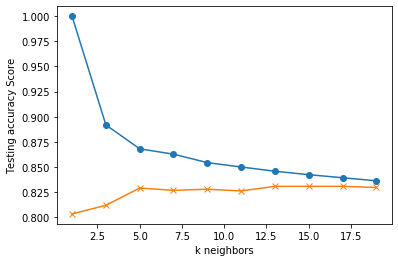

In [79]:
# Loop through different k values to see which has the highest accuracy
# Note: We only use odd numbers because we don't want any ties
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train_categorical)
    train_score = knn.score(X_train_scaled,y_train_categorical)
    test_score = knn.score(X_test_scaled, y_test_categorical)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()


In [81]:
# Note that k: 13 seems to be the best choice for this dataset
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train_scaled, y_train_categorical)
print('k=19 Test Acc: %.3f' % knn.score(X_test_scaled, y_test_categorical))

k=19 Test Acc: 0.831


# Hyperparameter Tuning

Use `GridSearchCV` to tune the model's parameters

In [96]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV
param_grid = {'bootstrap': [True], 'n_estimators' : [ 50,100,150, 200]
              }
grid = GridSearchCV(clf, param_grid, verbose=3)

In [97]:
# To get list of parameters you can tune
clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [98]:
# Train the model with GridSearch
grid.fit(X_train_scaled, y_train_categorical)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] bootstrap=True, n_estimators=50 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..... bootstrap=True, n_estimators=50, score=0.883, total=   0.8s
[CV] bootstrap=True, n_estimators=50 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ..... bootstrap=True, n_estimators=50, score=0.874, total=   0.7s
[CV] bootstrap=True, n_estimators=50 .................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s


[CV] ..... bootstrap=True, n_estimators=50, score=0.855, total=   0.7s
[CV] bootstrap=True, n_estimators=50 .................................
[CV] ..... bootstrap=True, n_estimators=50, score=0.889, total=   0.7s
[CV] bootstrap=True, n_estimators=50 .................................
[CV] ..... bootstrap=True, n_estimators=50, score=0.889, total=   0.7s
[CV] bootstrap=True, n_estimators=100 ................................
[CV] .... bootstrap=True, n_estimators=100, score=0.882, total=   1.4s
[CV] bootstrap=True, n_estimators=100 ................................
[CV] .... bootstrap=True, n_estimators=100, score=0.866, total=   1.6s
[CV] bootstrap=True, n_estimators=100 ................................
[CV] .... bootstrap=True, n_estimators=100, score=0.859, total=   1.5s
[CV] bootstrap=True, n_estimators=100 ................................
[CV] .... bootstrap=True, n_estimators=100, score=0.882, total=   1.5s
[CV] bootstrap=True, n_estimators=100 ................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   37.2s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=40,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=8,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=200, n_jobs=None,
                                              oob_score=False,
                                              rand

In [100]:
print(grid.best_params_)
print(grid.best_score_)

{'bootstrap': True, 'n_estimators': 50}
0.8781274787329263


# Save the Model

In [103]:
# saving model by updating filename
# andding my clf model with  model variable
# turning this in to BCS
import joblib
filename = 'model_1.sav'
joblib.dump(clf, filename)

['model_1.sav']